# Orchestrating training and deployment of R models with Vertex AI Pipelines


TODO: Writing model artifacts to GCS

In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<!-- <table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/ai-platform-samples/blob/master/ai-platform-unified/notebooks/notebook_template.ipynb"">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ai-platform-samples/blob/master/ai-platform-unified/notebooks/notebook_template.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table> -->

# Orchestrating a workflow to train and deploy a R model using [Vertex Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction)

## Overview

This tutorial uses R.A. Fisher's Iris dataset, a small dataset that is popular for trying out machine learning techniques. Each instance has four numerical features, which are different measurements of a flower, and a target label that marks it as one of three types of iris: Iris setosa, Iris versicolour, or Iris virginica. Flower classifier with an e2e example using [Vertex Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines).

This `kfp.v2` code currently does not run on OSS KFP, but will be able to soon once the 'v2 compatibility mode' feature is supported.


### Set up your local development environment

**If you are using Colab or Google Cloud Notebooks**, your environment already meets
all the requirements to run this notebook. You can skip this step.

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK
* Git
* Python 3
* virtualenv
* Jupyter notebook running in a virtual environment with Python 3

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

1. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

1. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3. Activate the virtual environment.

1. To install Jupyter, run `pip install jupyter` on the
command-line in a terminal shell.

1. To launch Jupyter, run `jupyter notebook` on the command-line in a terminal shell.

1. Open this notebook in the Jupyter Notebook Dashboard.

### Install additional packages



On colab, authenticate first:

In [ ]:
import sys
if 'google.colab' in sys.modules:
  from google.colab import auth
  auth.authenticate_user()

Then, install the libraries.

In [ ]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# Google Cloud Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

We will be using [Vertex SDK for Python](https://cloud.google.com/vertex-ai/docs/start/client-libraries#python) to interact with Vertex AI services. The high-level aiplatform library is designed to simplify common data science workflows by using wrapper classes and opinionated defaults.

#### Install Vertex SDK for Python

In [ ]:
!pip -q install {USER_FLAG} --upgrade kfp
!pip -q install {USER_FLAG} --upgrade google-cloud-pipeline-components 
!pip -q install {USER_FLAG} --upgrade google-cloud-aiplatform

### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [ ]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

Check the versions of the packages you installed.  The KFP SDK version should be >=1.6.

In [ ]:
! python3 -c "import kfp; print('kfp version: {}'.format(kfp.__version__))"
! python3 -c "import google_cloud_pipeline_components; print('google_cloud_pipeline_components version: {}'.format(google_cloud_pipeline_components.__version__))"

## Before you begin

This notebook does not require a GPU runtime.

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API and Compute Engine API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component). 
Also [enable the Cloud Build API](https://console.cloud.google.com/flows/enableapi?apiid=cloudbuild.googleapis.com).

1. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [ ]:
import os
# Get your Google Cloud project ID from gcloud
shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null

try:
    PROJECT_ID = shell_output[0]
except IndexError:
    PROJECT_ID = None

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Otherwise, set your project ID here.

In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "python-docs-samples-tests"  # @param {type:"string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [ ]:
from datetime import datetime

def get_timestamp():
    return datetime.now().strftime("%Y%m%d%H%M%S")

TIMESTAMP = get_timestamp()
print(f"TIMESTAMP = {TIMESTAMP}")

### Authenticate your Google Cloud account

**If you are using AI Platform Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

1. In the Cloud Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. Click **Create service account**.

3. In the **Service account name** field, enter a name, and
   click **Create**.

4. In the **Grant this service account access to project** section, click the **Role** drop-down list. Type "AI Platform"
into the filter box, and select
   **AI Platform Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

6. Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell.

In [ ]:
import os
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# If on AI Platform, then don't execute this code
if not os.path.exists("/opt/deeplearning/metadata/env_version"):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Create a Cloud Storage bucket as necessary

You will need a Cloud Storage bucket for this example.  If you don't have one that you want to use, you can make one now.


Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where AI Platform (Unified) services are
available](https://cloud.google.com/ai-platform-unified/docs/general/locations#available_regions). You may
not use a Multi-Regional Storage bucket for training with AI Platform.

**Change the bucket name below** before running the next cell.

In [ ]:
BUCKET_NAME = "gs://[your-bucket-name]"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}

In [ ]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "gs://[your-bucket-name]":
    BUCKET_NAME = "gs://" + PROJECT_ID + "aip-" + TIMESTAMP

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION $BUCKET_NAME

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al $BUCKET_NAME

### Import libraries and define constants



Define some constants. See the "Before you begin" section of the Managed Pipelines User Guide for information on creating your API key.


In [ ]:
os.environ["PROJECT_ID"] = PROJECT_ID
os.environ["BUCKET"] = BUCKET_NAME

In [ ]:
APP_NAME = "housing-price-predictor"

Do some imports:

In [ ]:
import json
from typing import NamedTuple, List

from google_cloud_pipeline_components import aiplatform as aip_components
from google_cloud_pipeline_components.v1 import custom_job, dataset, endpoint, model, batch_predict_job
from google_cloud_pipeline_components.types import artifact_types
from google.cloud import aiplatform
from google.cloud.aiplatform import pipeline_jobs

from kfp.v2 import compiler
from kfp.v2 import dsl
from kfp.v2 import components

In [ ]:
! mkdir ./src

### Introduction to Google Artifact Registry

The `Google Artifact Registry` is a service for storing and managing artifacts in private repositories, including container images, Helm charts, and language packages. It is the recommended container image registry for Google Cloud.

Learn more about [Quick start for Docker](https://cloud.google.com/artifact-registry/docs/docker/quickstart)

#### Enable Artifact Registry API

First, you must enable the Artifact Registry API service for your project.

Learn more about [Enabling service](https://cloud.google.com/artifact-registry/docs/enable-service).

In [ ]:
! gcloud services enable artifactregistry.googleapis.com

#### Create a private Docker repository

Your first step is to create your own Docker repository in Google Artifact Registry.

1. Run the `gcloud artifacts repositories create` command to create a new Docker repository with your region with the description "docker repository".

2. Run the `gcloud artifacts repositories list` command to verify that your repository was created.

In [ ]:
PRIVATE_REPO = "r-on-vertex"

In [ ]:
! gcloud artifacts repositories create $PRIVATE_REPO --repository-format=docker \
    --location=$REGION \
    --description="Docker repository"

! gcloud artifacts repositories list

#### Configure authentication to your private repo

Before you push or pull container images, configure Docker to use the `gcloud` command-line tool to authenticate requests to `Artifact Registry` for your region.

In [ ]:
! gcloud auth configure-docker $REGION-docker.pkg.dev --quiet

## Create training and serving scripts

### Create the training script

Next, create the file `train.R`, which is used to train your R model. The script trains a `randomForest` model on the California Housing dataset. Vertex AI sets environment variables that you can utilize, and since this script uses a Vertex AI managed dataset, data splits are performed by Vertex AI and the script receives environment variables pointing to the training, test, and validation sets.

The trained model artifacts are then stored to your Cloud Storage bucket.

In [ ]:
%%writefile src/train.R

#!/usr/bin/env Rscript
# filename: train.R - train a Random Forest model on Vertex AI Managed Dataset
library(tidyverse)
library(data.table)
library(randomForest)
Sys.getenv()

# The GCP Project ID
project_id <- Sys.getenv("CLOUD_ML_PROJECT_ID")

# The GCP Region
location <- Sys.getenv("CLOUD_ML_REGION")

# The Cloud Storage URI to upload the trained model artifact to
model_dir <- Sys.getenv("AIP_MODEL_DIR")

# Next, you create directories to download our training, validation, and test set into.
dir.create("training")
dir.create("validation")
dir.create("test")

# You download the Vertex AI managed data sets into the container environment locally.
system2("gsutil", c("cp", Sys.getenv("AIP_TRAINING_DATA_URI"), "training/"))
system2("gsutil", c("cp", Sys.getenv("AIP_VALIDATION_DATA_URI"), "validation/"))
system2("gsutil", c("cp", Sys.getenv("AIP_TEST_DATA_URI"), "test/"))

# For each data set, you may receive one or more CSV files that you will read into data frames.
training_df <- list.files("training", full.names = TRUE) %>% map_df(~fread(.))
validation_df <- list.files("validation", full.names = TRUE) %>% map_df(~fread(.))
test_df <- list.files("test", full.names = TRUE) %>% map_df(~fread(.))

print("Starting Model Training")
rf <- randomForest(median_house_value ~ ., data=training_df, ntree=100)
rf

saveRDS(rf, "rf.rds")
system2("gsutil", c("cp", "rf.rds", model_dir))

### Create the serving script

Next, create the file `serve.R`, which is used for serving your R model. The script downloads the model artifact from Cloud Storage, loads the model artifacts, and listens for prediction requests on port `8080`.

In [ ]:
%%writefile src/serve.R

#!/usr/bin/env Rscript
# filename: serve.R - serve predictions from a Random Forest model
Sys.getenv()
library(plumber)

system2("gsutil", c("cp", "-r", Sys.getenv("AIP_STORAGE_URI"), "."))
system("du -a .")

rf <- readRDS("artifacts/rf.rds")
library(randomForest)

predict_route <- function(req, res) {
    print("Handling prediction request")
    df <- as.data.frame(req$body$instances)
    preds <- predict(rf, df)
    return(list(predictions=preds))
}

print("Staring Serving")

pr() %>%
    pr_get(Sys.getenv("AIP_HEALTH_ROUTE"), function() "OK") %>%
    pr_post(Sys.getenv("AIP_PREDICT_ROUTE"), predict_route) %>%
    pr_run(host = "0.0.0.0", port=as.integer(Sys.getenv("AIP_HTTP_PORT", 8080)))

## Build and push container image

### Create Dockerfile

The docker file for your custom container is built on top of the Deep Learning container -- the same container that is also used for Vertex AI Workbench. In addition, you add two R scripts for model training and serving, respectively.

In [ ]:
IMAGE_NAME = "vertex-r"  # @param {type:"string"}
IMAGE_TAG = "latest"  # @param {type:"string"}
IMAGE_URI = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{PRIVATE_REPO}/{IMAGE_NAME}:{IMAGE_TAG}"

os.environ["IMAGE_URI"] = IMAGE_URI

IMAGE_URI

In [ ]:
%%writefile ./src/Dockerfile

# filename: Dockerfile - container specifications for using R in Vertex AI
FROM gcr.io/deeplearning-platform-release/r-cpu.4-1:latest

WORKDIR /root

COPY train.R /root/train.R
COPY serve.R /root/serve.R

# Install Fortran
RUN apt-get update
RUN apt-get install gfortran -yy

# Install R packages
RUN R -e 'install.packages(c("plumber"))'
RUN R -e 'install.packages(c("randomForest"))'

EXPOSE 8080

### Build the Docker container

Next, you build the Docker container image on Cloud Build -- the serverless CI/CD platform.

*Note:* Building the Docker container image may take 10 to 15 minutes.

In [ ]:
! gcloud builds submit --region=$REGION --tag=$IMAGE_URI --timeout=1h ./src

## Define the pipeline components



In [ ]:
! mkdir -p ./src/pipelines

### Custom component to test model deployment making online prediction requests

In [ ]:
@dsl.component(
    #base_image="gcr.io/google.com/cloudsdktool/cloud-sdk:latest",
    base_image="python:3.9",
    packages_to_install=["google-cloud-build", "google-cloud-aiplatform"],
    output_component_file="./src/pipelines/make_prediction_request.yaml")
def make_prediction_request( 
    endpoint: str,
    payload: List
    ):
    import logging
    import subprocess
    import json
    import ast
    import google.auth
    import google.auth.transport.requests
    creds, project = google.auth.default()

    # creds.valid is False, and creds.token is None
    # Need to refresh credentials to populate those

    auth_req = google.auth.transport.requests.Request()
    creds.refresh(auth_req)

    logging.info(f"Endpoint: {endpoint}")
    endpoint = ast.literal_eval(endpoint)
    endpoint_uri = endpoint["resources"][0]["resourceUri"]
    endpoint_uri = "/".join(endpoint_uri.split("/")[:-2])
    endpoint_uri = f"{endpoint_uri}:predict"
    logging.info(f"Endpoint: {endpoint_uri}")

    curl_cmd = f'''curl -s \
    -X POST \
    -H "Authorization: Bearer {creds.token}" \
    -H "Content-Type: application/json" \
    {endpoint_uri} \
    -d '{json.dumps(payload)}'
    '''

    status, output = subprocess.getstatusoutput(curl_cmd)
    logging.info(f"status: {status}")
    logging.info(f"output: {output}")
    predictions = json.loads(output)
    logging.info(f"Prediction response: {predictions}")

## Define Configuration

In [ ]:
%%writefile ./src/config.py

import os
from datetime import datetime

PROJECT_ID = os.getenv("PROJECT_ID", "")
BUCKET = os.getenv("BUCKET", "")
REGION = os.getenv("REGION", "us-central1")

R_CUSTOM_IMAGE_URI = os.getenv("IMAGE_URI")

DATASET_NAME = "ca-housing-data"

APP_NAME = os.getenv("APP_NAME", "housing-price-predictor")
MODEL_NAME = APP_NAME
MODEL_DISPLAY_NAME = f"{MODEL_NAME}"

PIPELINE_NAME = f"r-{APP_NAME}"
PIPELINE_ROOT = f"{BUCKET}/pipeline_root/{MODEL_NAME}"
GCS_STAGING = f"{BUCKET}/pipeline_root/{MODEL_NAME}"

TRAIN_MACHINE_TYPE = "n1-standard-4"
TRAIN_REPLICA_COUNT = "1"

SERVING_MACHINE_TYPE = "n1-standard-4"
SERVING_MIN_REPLICA_COUNT = 1
SERVING_MAX_REPLICA_COUNT=1
SERVING_TRAFFIC_SPLIT='{"0": 100}'

In [ ]:
from src import config

In [ ]:
# create working dir to pass to job spec
WORKING_DIR = f"{config.PIPELINE_ROOT}/{TIMESTAMP}"
GCS_TEST_BATCH_URI = f"{config.PIPELINE_ROOT}/data/test/batch_input.jsonl"

## Sample file for testing predictions

In [ ]:
%%writefile batch_input.jsonl
{"longitude":-122.23,"latitude":37.88,"housing_median_age":41,"total_rooms":880,"total_bedrooms":129,"population":322,"households":126,"median_income":8.3252}
{"longitude":-122.22,"latitude":37.86,"housing_median_age":21,"total_rooms":7099,"total_bedrooms":1106,"population":2401,"households":1138,"median_income":8.3014}
{"longitude":-122.24,"latitude":37.85,"housing_median_age":52,"total_rooms":1467,"total_bedrooms":190,"population":496,"households":177,"median_income":7.2574}
{"longitude":-122.25,"latitude":37.85,"housing_median_age":52,"total_rooms":1274,"total_bedrooms":235,"population":558,"households":219,"median_income":5.6431}
{"longitude":-122.25,"latitude":37.85,"housing_median_age":52,"total_rooms":1627,"total_bedrooms":280,"population":565,"households":259,"median_income":3.8462}

In [ ]:
! cat batch_input.jsonl | gsutil cp - $GCS_TEST_BATCH_URI
! gsutil cat $GCS_TEST_BATCH_URI

## Define Pipeline

In [ ]:
@dsl.pipeline(
    name=config.PIPELINE_NAME,
    pipeline_root=config.PIPELINE_ROOT
)
def r_pipeline(
    dataset_uri: str
):
    from src import config
        
    # create dataset
    create_dataset_task = dataset.TabularDatasetCreateOp(
        display_name=config.DATASET_NAME,
        gcs_source=dataset_uri,
        project=config.PROJECT_ID,
        location=config.REGION,
    ).set_display_name("Create Managed Dataset")

    # train the model on Vertex AI by submitting a CustomJob 
    run_train_task = (
        aip_components.CustomContainerTrainingJobRunOp(
            project=config.PROJECT_ID,
            location=config.REGION,
            display_name="Run model Training",
            dataset=create_dataset_task.outputs["dataset"],
            replica_count=config.TRAIN_REPLICA_COUNT,
            machine_type=config.TRAIN_MACHINE_TYPE,
            container_uri=config.R_CUSTOM_IMAGE_URI, 
            command=["Rscript", "train.R"],
            model_display_name=config.MODEL_DISPLAY_NAME,
            model_serving_container_image_uri=config.R_CUSTOM_IMAGE_URI,
            model_serving_container_command=["Rscript", "serve.R"],
            model_serving_container_predict_route='/predict',
            model_serving_container_health_route='/health',
            staging_bucket=config.BUCKET,
            base_output_dir=WORKING_DIR
        )
        .set_display_name("Run custom training job")
        .set_caching_options(False)
    )

    # create endpoint to deploy one or more models
    # An endpoint provides a service URL where the prediction requests are sent
    endpoint_create_task = (
        endpoint.EndpointCreateOp(
            project=config.PROJECT_ID,
            display_name=config.MODEL_DISPLAY_NAME)
        .set_display_name("Create endpoint")
        .after(run_train_task)
        .set_caching_options(False)
    )

    # deploy models to endpoint to associates physical resources with the model 
    # so it can serve online predictions 
    model_deploy_task = (
        endpoint.ModelDeployOp(
            endpoint=endpoint_create_task.outputs["endpoint"],
            model=run_train_task.outputs["model"],
            deployed_model_display_name=config.MODEL_DISPLAY_NAME,
            dedicated_resources_machine_type=config.SERVING_MACHINE_TYPE,
            dedicated_resources_min_replica_count=config.SERVING_MIN_REPLICA_COUNT,
            dedicated_resources_max_replica_count=config.SERVING_MAX_REPLICA_COUNT,
            traffic_split=config.SERVING_TRAFFIC_SPLIT)
        .set_caching_options(False)
        .set_display_name("Deploy model to endpoint")
    )

    # test model deployment by making online prediction requests
    payload = {"instances":[{
        "longitude":-122.23,
        "latitude":37.88,
        "housing_median_age":41,
        "total_rooms":880,
        "total_bedrooms":129,
        "population":322,
        "households":126,
        "median_income":8.3252}]}

    predict_test_instances_task = (
        make_prediction_request(
            model_deploy_task.outputs["gcp_resources"],
            payload)
        .set_caching_options(False)
        .set_display_name("Test model deployment")
    )
    
    # run batch predictions 
    model_batch_prediction_task = (
        batch_predict_job.ModelBatchPredictOp(
            project=config.PROJECT_ID,
            location=config.REGION,
            job_display_name=f"batch-{config.MODEL_DISPLAY_NAME}",
            model=run_train_task.outputs["model"],
            gcs_source_uris=[GCS_TEST_BATCH_URI],
            gcs_destination_output_uri_prefix=f"{WORKING_DIR}/results/",
            predictions_format='jsonl',
            machine_type=config.SERVING_MACHINE_TYPE,
            starting_replica_count=config.SERVING_MIN_REPLICA_COUNT,
            max_replica_count=config.SERVING_MAX_REPLICA_COUNT
        )
        .set_caching_options(False)
        .set_display_name("Run batch predictions")
        .after(predict_test_instances_task)
    )


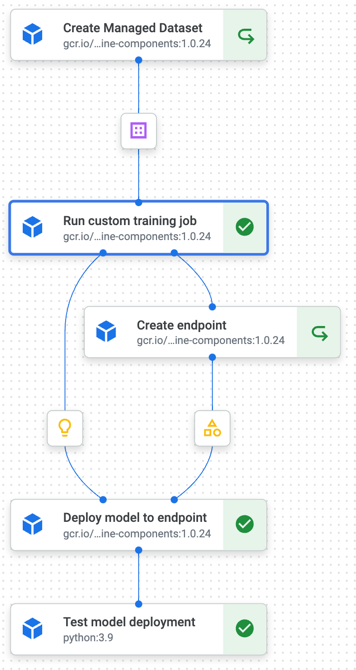

## Compile and submit pipeline

In [ ]:
PIPELINE_JSON_SPEC_PATH = './src/pipelines/r-housing-price-predictor-pipeline-spec.json'
compiler.Compiler().compile(
    pipeline_func=r_pipeline,
    package_path=PIPELINE_JSON_SPEC_PATH)

In [ ]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME)

In [ ]:
PIPELINE_JOB_ID = f"pipeline-{APP_NAME}-{get_timestamp()}"
pipeline_params = {
    "dataset_uri": "gs://cloud-samples-data/ai-platform-unified/datasets/tabular/california-housing-tabular-regression.csv" 
}

In [ ]:
pipeline_job = pipeline_jobs.PipelineJob(
    display_name=config.PIPELINE_NAME,
    pipeline_root=config.PIPELINE_ROOT,
    job_id=PIPELINE_JOB_ID,
    template_path=PIPELINE_JSON_SPEC_PATH,
    parameter_values=pipeline_params,
    enable_caching=True
)

In [ ]:
response = pipeline_job.run(sync=False)
response

In [ ]:
df = aiplatform.get_pipeline_df(pipeline=config.PIPELINE_NAME.replace("_", "-"))
df